In [184]:
import logging

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import photutils
from photutils.datasets import make_4gaussians_image
from photutils.morphology import centroid_com, centroid_1dg, centroid_2dg

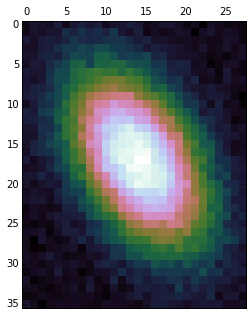

In [185]:
data = make_4gaussians_image()[43:79, 76:104]
plt.matshow(data, cmap="cubehelix")

In [186]:
x1, y1 = centroid_com(data)
print x1, y1

13.9315799834 17.0512344411


In [187]:
x2, y2 = centroid_1dg(data)
print x2, y2 

14.0403527074 16.9623064636


In [188]:
x3, y3 = centroid_2dg(data)
print x3, y3

14.0022120737 16.996134593


(0, 35)

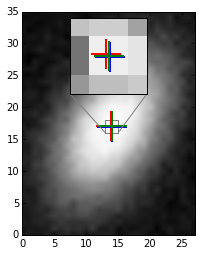

In [189]:
fig, ax = plt.subplots(1, 1)
ax.imshow(data, origin='lower', cmap='Greys_r')
marker = '+'
ms, mew = 30, 2.
plt.plot(x1, y1, color='red', marker=marker, ms=ms, mew=mew)
plt.plot(x2, y2, color='blue', marker=marker, ms=ms, mew=mew)
plt.plot(x3, y3, color='green', marker=marker, ms=ms, mew=mew)
ax2 = zoomed_inset_axes(ax, zoom=6, loc=9)
ax2.imshow(data, interpolation='nearest', origin='lower',
           cmap='Greys_r', vmin=190, vmax=220)
ax2.plot(x1, y1, color='red', marker=marker, ms=ms, mew=mew)
ax2.plot(x2, y2, color='blue', marker=marker, ms=ms, mew=mew)
ax2.plot(x3, y3, color='green', marker=marker, ms=ms, mew=mew)
ax2.set_xlim(13, 15)
ax2.set_ylim(16, 18)
mark_inset(ax, ax2, loc1=3, loc2=4, fc='none', ec='0.5')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax.set_xlim(0, data.shape[1]-1)
ax.set_ylim(0, data.shape[0]-1)

In [190]:
from k2phot import centroid
x5, y5 = centroid.daofind_centroid(data)
x6, y6 = centroid.flux_weighted_centroid(data, 25, init=(x1,y1))
print x5, y5
print x6, y6

xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--------- --------- --------- ---------- ---------- ---- --- ---- ---- --- 0
17.2009779682 13.5419455122


(0, 35)

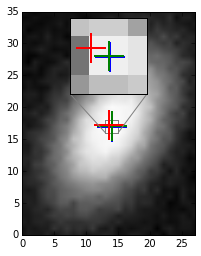

In [191]:
fig, ax = plt.subplots(1, 1)
ax.imshow(data, origin='lower', cmap='Greys_r')
marker = '+'
ms, mew = 30, 2.
plt.plot(x2, y2, color='blue', marker=marker, ms=ms, mew=mew)
plt.plot(x3, y3, color='green', marker=marker, ms=ms, mew=mew)
plt.plot(y6, x6, color='red', marker=marker, ms=ms, mew=mew)
ax2 = zoomed_inset_axes(ax, zoom=6, loc=9)
ax2.imshow(data, interpolation='nearest', origin='lower',
           cmap='Greys_r', vmin=190, vmax=220)
plt.plot(x2, y2, color='blue', marker=marker, ms=ms, mew=mew)
plt.plot(x3, y3, color='green', marker=marker, ms=ms, mew=mew)
ax2.plot(y6, x6, color='red', marker=marker, ms=ms, mew=mew)
ax2.set_xlim(13, 15)
ax2.set_ylim(16, 18)
mark_inset(ax, ax2, loc1=3, loc2=4, fc='none', ec='0.5')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax.set_xlim(0, data.shape[1]-1)
ax.set_ylim(0, data.shape[0]-1)

xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--------- --------- --------- ---------- ---------- ---- --- ---- ---- --- 0


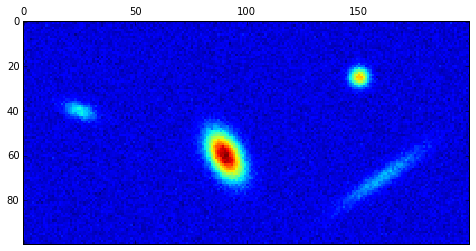

In [192]:
data2 = make_4gaussians_image()
coords, nc = centroid.daofind_centroid(data2)
print coords, nc
plt.matshow(data2)

In [193]:
from photutils.morphology import data_properties
from photutils import properties_table, EllipticalAperture

In [194]:
from astropy.stats import sigma_clipped_stats
sigma_clipped_stats?

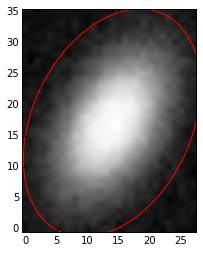

In [195]:
props = data_properties(data)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = properties_table(props, columns=columns)
r = 2.5    # approximate isophotal extent
position = (props.xcentroid.value, props.ycentroid.value)
a = props.semimajor_axis_sigma.value * r
b = props.semiminor_axis_sigma.value * r
theta = props.orientation.value
apertures = EllipticalAperture(position, a, b, theta=theta)
plt.imshow(data, origin='lower', cmap='Greys_r')
apertures.plot(color='red')

In [196]:
from k2phot import tpf_io
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
def find_ellip(filename, r=3, cutout_kwargs=None):
    """
    Compute properties of an image (basically fit a 2D Gaussian) and
    determine the corresponding elliptical aperture. 
    
    inputs:
    -------
    filename: string
    
    r: float
        isophotal extent (multiplied by semi-major axes of fitted
        gaussian to determine the elliptical aperture)
        
    extents: array-like, optional
        xmin, xmax, ymin, ymax of sub-image
    """
    table, times, pixels, maskmap, maskheader = tpf_io.get_data(filename)
    if cutout_kwargs is None:
        coadd = np.sum(pixels, axis=0)
        cmask = (maskmap==0)
    else:
        coadd = np.sum(pixels, axis=0)
        cmask = (maskmap==0)
        coadd, cmask, cerr, cslice = photutils.morphology.cutout_footprint(coadd, mask=cmask, **cutout_kwargs)
    mean, median, std = sigma_clipped_stats(coadd, mask=cmask, sigma=3.0, iters=3)
    cprops = data_properties(coadd - median, mask=cmask, background = median)
    tbl = properties_table(cprops, columns=columns)
    print tbl
    position = (cprops.xcentroid.value, cprops.ycentroid.value)
    a = cprops.semimajor_axis_sigma.value * r
    b = cprops.semiminor_axis_sigma.value * r
    theta = cprops.orientation.value
    apertures = EllipticalAperture(position, a, b, theta=theta)
    plt.matshow(coadd, origin='lower', cmap='Greys_r')
    apertures.plot(color='red')

 id   xcentroid     ycentroid   ... semiminor_axis_sigma  orientation 
         pix           pix      ...         pix               rad     
--- ------------- ------------- ... -------------------- -------------
  1 8.47246749263 9.22942332198 ...        1.25156232207 1.18370555521


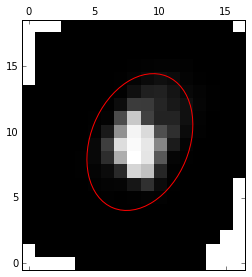

In [197]:
filename = "/home/stephanie/code/python/k2phot/tpf/ktwo202539362-c02_lpd-targ.fits.gz"
find_ellip(filename)

 id   xcentroid     ycentroid   ... semiminor_axis_sigma  orientation  
         pix           pix      ...         pix               rad      
--- ------------- ------------- ... -------------------- --------------
  1 5.85104218115 8.81300985517 ...        1.92721043976 0.206500266946


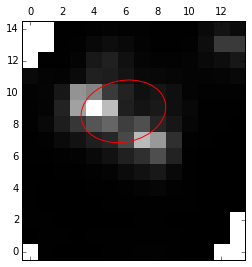

In [198]:
filename = "/home/stephanie/code/python/k2phot/tpf/ktwo202521690-c02_lpd-targ.fits.gz"
find_ellip(filename, r=1)#, extents=[4,10,6,10])

 id   xcentroid      ycentroid   ... semiminor_axis_sigma   orientation  
         pix            pix      ...         pix                rad      
--- -------------- ------------- ... -------------------- ---------------
  1 0.956976281988 2.90900800786 ...       0.366353552909 -0.747797962305


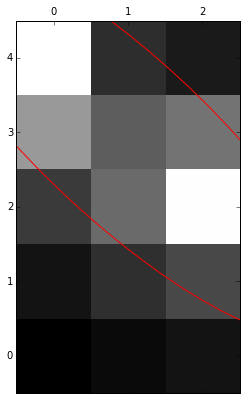

In [199]:
cutout_kwargs = {"position":(sources[0]["xcentroid"], sources[0]["ycentroid"]),
                 "box_size":(5,3)}
find_ellip(filename, cutout_kwargs=cutout_kwargs)

In [200]:
filename = "/home/stephanie/code/python/k2phot/tpf/ktwo202521690-c02_lpd-targ.fits.gz"
table, times, pixels, maskmap, maskheader = tpf_io.get_data(filename)
coadd = np.sum(pixels, axis=0)
cmask = (maskmap==0)
mean, median, std = sigma_clipped_stats(coadd, mask=cmask, sigma=3.0, iters=3)
print median

1.9392e+06


In [201]:
sources, n = centroid.daofind_centroid(coadd)
print sources

 id   xcentroid     ycentroid   ...    peak         flux          mag      
--- ------------- ------------- ... ---------- ------------- --------------
  1 7.34787187823 7.15144263669 ... 49544876.0 35993.3119695 -11.3905545266
  2 4.03695747834 9.09692313334 ... 79667704.0 64553.5990898 -12.0248011518
  3 12.3517367874 12.9304317704 ... 16079732.0 14507.7711031 -10.4040017372


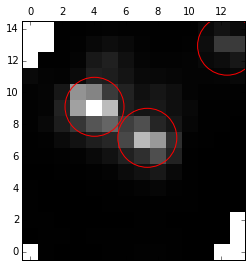

In [202]:
connect_slope = (sources[0]["ycentroid"] - sources[1]["ycentroid"]) / (sources[0]["xcentroid"] - sources[1]["ycentroid"])
connect_int = sources[0]["ycentroid"] - connect_slope * sources[0]["xcentroid"]
sep = np.sqrt((sources[0]["ycentroid"] - sources[1]["ycentroid"])**2 + (sources[0]["xcentroid"] - sources[1]["ycentroid"])**2)
r = sep / np.sqrt(2.0)
apertures = photutils.CircularAperture((sources["xcentroid"], sources["ycentroid"]), r=r)
plt.matshow(coadd, origin='lower', cmap='Greys_r')
apertures.plot(color='red')

In [203]:
flux1 = np.zeros(len(pixels))
flux2 = np.zeros(len(pixels))
pos1 = np.zeros(len(pixels)*2).reshape((-1,2))
pos2 = np.zeros(len(pixels)*2).reshape((-1,2))
for i, p in enumerate(pixels):
    mean, median, std = sigma_clipped_stats(p, mask=cmask, sigma=3.0, iters=3)
    sources, n = centroid.daofind_centroid(p)
    if n<2:
        continue
    pos1[i,0] = sources[0]["xcentroid"]
    pos1[i,1] = sources[0]["ycentroid"]
    pos2[i,0] = sources[1]["xcentroid"]
    pos2[i,1] = sources[1]["ycentroid"]

    sep = np.sqrt((sources[0]["ycentroid"] - sources[1]["ycentroid"])**2 + (sources[0]["xcentroid"] - sources[1]["ycentroid"])**2)
    r = sep / np.sqrt(2.0)
    apertures = photutils.CircularAperture((sources["xcentroid"], sources["ycentroid"]), r=r)
    phot_table = photutils.aperture_photometry(p - median, apertures)
    flux1[i] = phot_table["aperture_sum"][0]
    flux2[i] = phot_table["aperture_sum"][1]


/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


(45000, 105000)

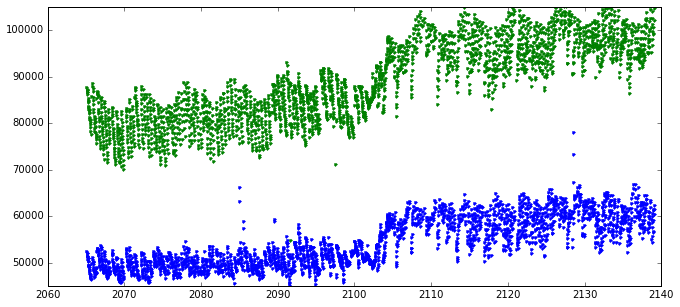

In [204]:
plt.figure(figsize=(11,5))
plt.plot(times[times>2065], flux1[times>2065], '.')
plt.plot(times[times>2065], flux2[times>2065], '.')
plt.ylim(45000,105000)

/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


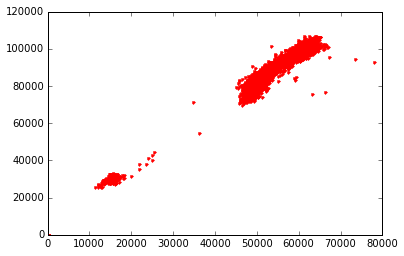

In [205]:
plt.plot(flux1[times>2065], flux2[times>2065], 'r.')

[[ 5.21435019  5.73619171]
 [ 5.22459178  5.75166091]
 [ 5.20267066  5.7494223 ]
 ..., 
 [ 7.20384537  7.40709723]
 [ 7.07815854  7.43400616]
 [ 6.97735467  7.46469923]]
[[ 10.43325423  11.60441903]
 [ 10.44070082  11.62300307]
 [ 10.4252617   11.62643751]
 ..., 
 [  3.6913337    9.5061939 ]
 [  3.59608574   9.55664988]
 [ 12.13803473  13.18547305]]


(6, 10)

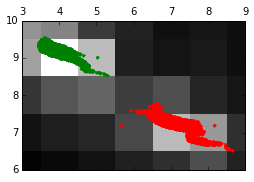

In [206]:
plt.matshow(coadd, origin='lower', cmap='Greys_r')
print pos1
print pos2
plt.plot(pos1[:,0], pos1[:,1], 'r.')
plt.plot(pos2[:,0], pos2[:,1], 'g.')
plt.xlim(3,9)
plt.ylim(6,10)

That is a bit concerning - the centroid positions should track together for two stars on the same chip. 

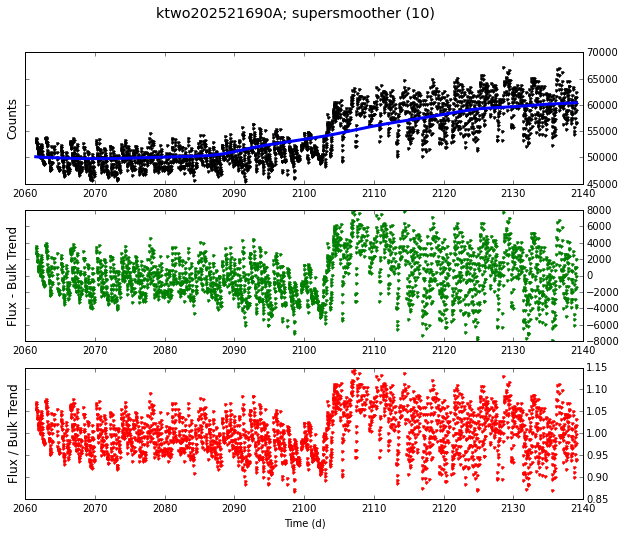

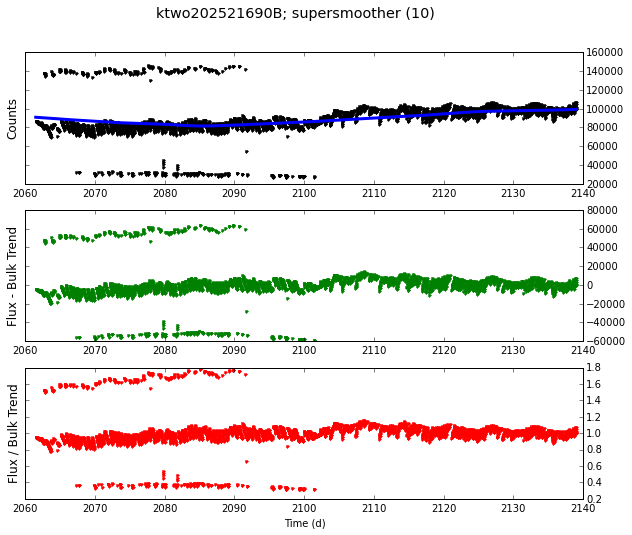

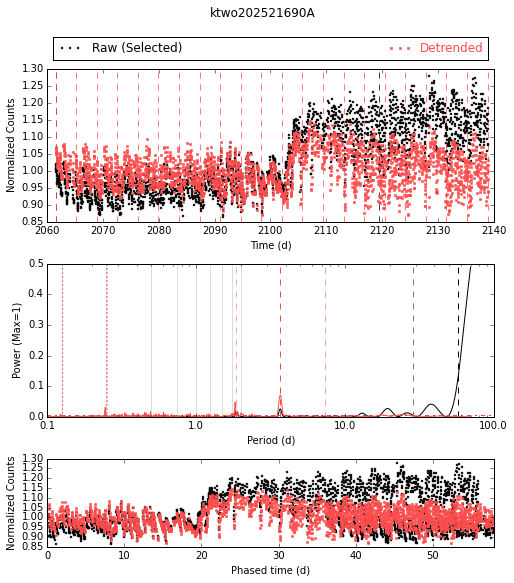

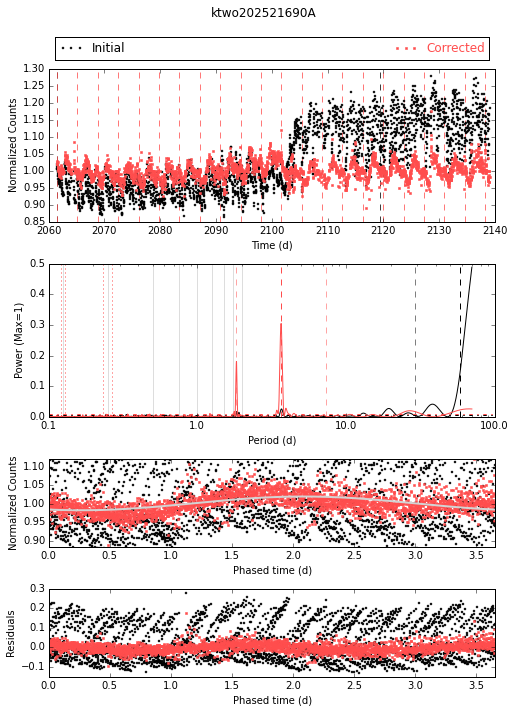

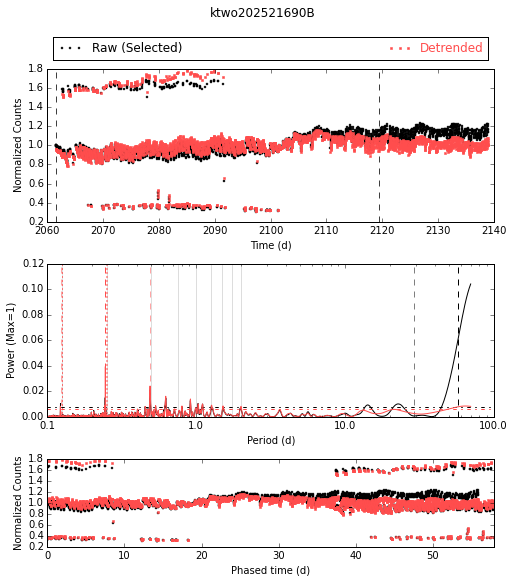

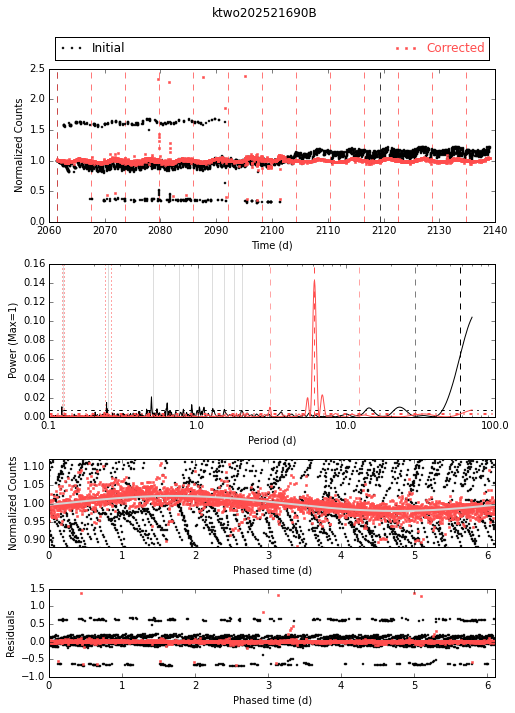

In [207]:
from k2spin import lc
from k2spin import k2io
from k2spin import plot

lc1 = lc.LightCurve(times, flux1, np.ones_like(flux1)*0.01, pos1[:,0], pos1[:,1], name="ktwo202521690A",
                    detrend_kwargs={"kind":"supersmoother","phaser":10})
lc2 = lc.LightCurve(times, flux2, np.ones_like(flux2)*0.01, pos2[:,0], pos2[:,1], name="ktwo202521690B",
                    detrend_kwargs={"kind":"supersmoother","phaser":10})

lc1.choose_initial()
lc1.correct_and_fit()

lc2.choose_initial()
lc2.correct_and_fit()

A (fainter) has a period of 3.5 d, while B (brighter) has a period of 6 d. They should be superimposed a bit, because the flux doesn't reach 0 between them so their PSFs are overlapping, but quite impressively you pretty much can't see the periods in each other's lightcurves. 

I don't know if iterative detrending ran on these, but a more careful selection of periods to whiten on would probably preclude that 6-hour peak being selected as the maximum initially